In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def regression(data, index):
    """
    Fast regression for spatial `data` onto 1d `index`.
    """

    data_flat = data.reshape(data.shape[0], np.product(data.shape[1:]))
    
    index = np.vstack((np.ones(len(index)), index)).T
    beta_hat = np.linalg.inv(index.T.dot(index)).dot(index.T).dot(data_flat)
    
    b0, b1 = beta_hat[0], beta_hat[1]
    b0 = b0.reshape((data.shape[1], data.shape[2]))
    b1 = b1.reshape((data.shape[1], data.shape[2]))

    return b0, b1

> Fast regression for spatial data onto 1d index.

* `data` is a n-d array

* `index` is a 1d array

order of `data` must be (time, lat, lon) order of `index` (time)

Can be used for calculating regression maps. For example regression of SST anomalies in the North Atlantic Region onto AMO.

In [3]:
time = np.linspace(1, 100, 100)
lat, lon = np.ogrid[-45:45:50j, 0:360:100j]

noise = 5 * np.sin(np.random.randn(time.shape[0], 
                                   lat.shape[0],
                                   lon.shape[1])/2*np.pi)

data_vars = {'noise': (['time', 'lat', 'lon'], noise)}
coords = {'time': time, 'lat': lat.ravel(), 'lon': lon.ravel()}
dataset = xr.Dataset(data_vars, coords)

In [4]:
index = np.sin(time/2*np.pi)

In [5]:
a0, a1 = regression(dataset.noise.values, index)

In [6]:
dataset['a0'] = (("lat", "lon"), a0)
dataset['a1'] = (("lat", "lon"), a1)

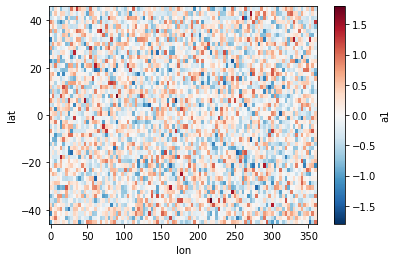

In [7]:
dataset['a1'].plot()

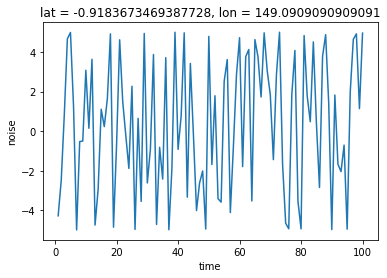

In [8]:
aoi = dataset.sel(lon = 150, lat = 0, method = "nearest")
aoi.noise.plot()

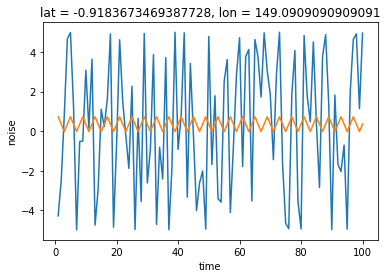

In [9]:
aoi.noise.plot()
plt.plot(aoi.time, aoi['a0'].values + aoi['a1'].values * index)

### AMO example

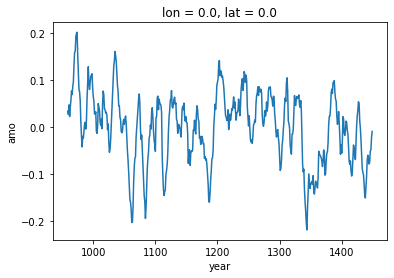

In [23]:
ds_amo = xr.open_dataset("/fast/boergel/paper/spatial_amo_baltic_sea/data/ocean/piControl/amo/amo_ACCESS-CM2_piControl_r1i1p1f1_tos_remap.nc",
                     use_cftime = True).groupby("time.year").mean()
ds_amo = ds_amo.rename({"__xarray_dataarray_variable__": "amo"})
ds_amo.amo.plot()

In [18]:
ds_north_atlantic = xr.open_dataset("/fast/boergel/paper/spatial_amo_baltic_sea/data/ocean/piControl/north_atlantic_region/ACCESS-CM2_piControl_r1i1p1f1_tos_remap.nc",
                                   use_cftime = True)
ds_north_atlantic = ds_north_atlantic.groupby("time.year").mean()
ds_north_atlantic

<xarray.Dataset>
Dimensions:  (lat: 240, lon: 321, year: 500)
Coordinates:
  * lon      (lon) float64 -80.0 -79.75 -79.5 -79.25 ... -0.75 -0.5 -0.25 0.0
  * lat      (lat) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * year     (year) int64 950 951 952 953 954 955 ... 1445 1446 1447 1448 1449
Data variables:
    tos      (year, lat, lon) float32 nan nan nan ... 10.040857 10.02696

In [24]:
a0, a1 = regression(ds_north_atlantic.isel(year = slice(11, -1)).tos.values,
                    ds_amo.amo.isel(year = slice(11, -1)).values)

In [28]:
ds = ds_north_atlantic.drop_vars("tos")
ds['a1'] = (("lat","lon"), np.asarray(a1))

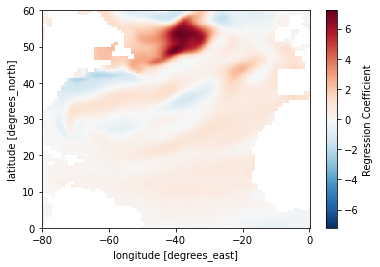

In [31]:
ds.a1.plot(cbar_kwargs={'label': "Regression Coefficient"})

In nice:

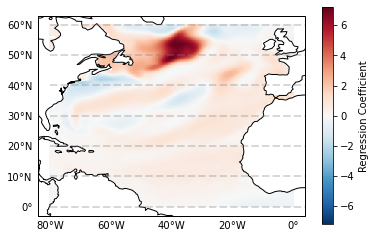

In [52]:
try:
    import cartopy.crs as ccrs
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    import matplotlib.ticker as mticker
except:
    print("Missing some modules for printing")


p = ds.a1.plot(cbar_kwargs={'label': "Regression Coefficient"},
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree())
p.axes.coastlines()

gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.3, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = True
gl.xlines = False
gl.xlocator = mticker.FixedLocator([-80, -60,-40,-20,-0,20,40])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER